# Sample implementation using Segment.py
* Experimentation - didn't work.
* Next attempt is to change SegmentNet to output x,y points instead of ypred

In [85]:
from segment import Segment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

# MultiLayer Model

In [108]:
class MultiLayerSegmentNet(nn.Module):
    def __init__(self, in_features, out_features, segment_features):
        super(MultiLayerSegmentNet, self).__init__()

        self.l1 = Segment(in_features, segment_features, segment_features)
        self.l2 = Segment(segment_features, out_features, segment_features)
        #self.l3 = Segment(1, in_features, segment_features)
 
    def custom_init(self, x_min, x_max):
        self.l1.custom_init(x_min, x_max)
        self.l2.custom_init(x_min, x_max)
        #self.l3.custom_init(x_min, x_max)

    def forward(self, x_in):
        self.y1 = self.l1.forward(x_in)
        self.y2 = self.l2.forward(self.y1)
        #self.y3 = self.l3.forward(self.y2)
        return self.y2

# Create Test Dataset

In [87]:
def f_quartic(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    return a*x**4 + b*x**3 + c*x**2 + d*x + f

def normalize(x,y):
    x_normalized = torch.nn.functional.normalize(x, dim=0)
    y_normalized = torch.nn.functional.normalize(y, dim=0)
    return x_normalized, y_normalized

In [88]:
# Create dataset
x_in = torch.arange(-1.5, 11., .05)
ytest = f_quartic(x_in)
#normalization - important
x_in, ytest = normalize(x_in, ytest)
print(x_in.shape, ytest.shape)

# Reshape x, ytest to N,1
x_in = x_in.view(x_in.shape[0], 1)
ytest = ytest.reshape(x.shape[0], 1)
print(x_in.shape, ytest.shape)

torch.Size([250]) torch.Size([250])
torch.Size([250, 1]) torch.Size([250, 1])


# Model Init

In [109]:
torch.manual_seed(10)

model = MultiLayerSegmentNet(x_in.shape[1], ytest.shape[1], 4)
#model = Segment(x_in.shape[1], ytest.shape[1], 4)

#Initialize model parameters - extremely important.
model.custom_init(x_in.min(dim=0).values, x_in.max(dim=0).values)

criterion = nn.MSELoss(reduction='sum')

lr=.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)

# create dataset that can be used in a dataloader 
dataset = torch.utils.data.TensorDataset(x_in, ytest)
batch_size=64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


IndexError: index 1 is out of bounds for dimension 0 with size 1

## Training Loop

In [105]:
num_epochs = 2000
losses = np.array([])
for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        # Forward pass
        [X, Y] = data
        ypred = model(X)
        # Calculate the loss
        loss = criterion(ypred, Y)
        train_loss += loss.item()
        
        # Backward and optimize
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    if epoch % (num_epochs/10) == 0:
        losses = np.append(losses, train_loss)
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss))

====> Epoch: 200 Average loss: 0.0332
====> Epoch: 400 Average loss: 0.0127
====> Epoch: 600 Average loss: 0.0054
====> Epoch: 800 Average loss: 0.0051
====> Epoch: 1000 Average loss: 0.0050
====> Epoch: 1200 Average loss: 0.0050
====> Epoch: 1400 Average loss: 0.0049
====> Epoch: 1600 Average loss: 0.0048
====> Epoch: 1800 Average loss: 0.0048
====> Epoch: 2000 Average loss: 0.0047


last total_mean_loss  0.004682992119342089


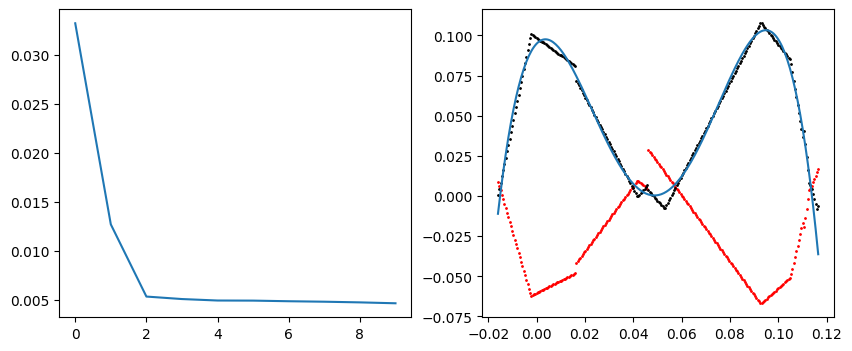

In [106]:
# plot graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (10, 4) # this is done to increase width to 

# Create a figure and two axes objects
# Increase the figure size to accommodate wider plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot loss
print ("last total_mean_loss ",train_loss)
ax1.plot(losses)

# plot trained model
y = model(x_in)
y1 = model.y1.detach().numpy()
#y2 = model.y2.detach().numpy()
y = y.detach().numpy()
ax2.plot(x_in, ytest)
ax2.scatter(x_in, y1, color='red', s=1)
#ax2.scatter(x_in, y2, color='green', s=1)
ax2.scatter(x_in, y, color='black', s=1)

# Display the plot
plt.show()

# Plot model parameters

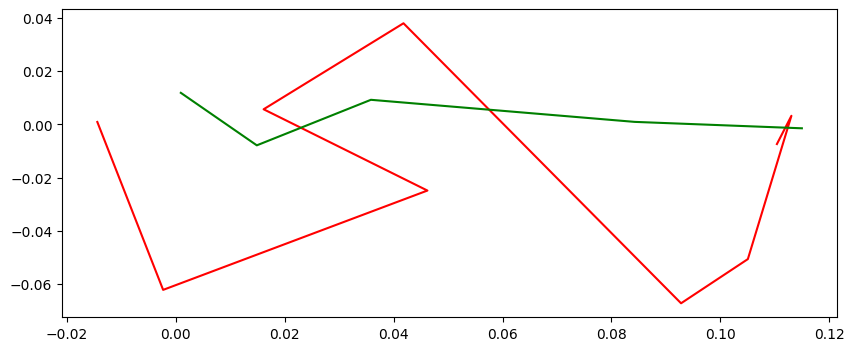

In [107]:
xval1 = model.l1.x.reshape(model.l1.x.shape[1]).detach().numpy()
yval1 = model.l1.y.reshape(model.l1.x.shape[1]).detach().numpy()
xval2 = model.l2.x.reshape(model.l2.x.shape[1]).detach().numpy()
yval2 = model.l2.y.reshape(model.l2.x.shape[1]).detach().numpy()
#xval3 = model.l3.x.reshape(model.l3.x.shape[1]).detach().numpy()
#yval3 = model.l3.y.reshape(model.l3.x.shape[1]).detach().numpy()
plt.plot(xval1,yval1,c='red') 
plt.plot(xval2,yval2,c='green') 
#plt.plot(xval3,yval3, c='black') 
plt.show()